# Random Forest Model

In [1]:
import numpy as np 
import pandas as pd

### Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

### Modeling tools
from sklearn.ensemble import RandomForestRegressor

### Evaluation tools
from sklearn.metrics import mean_absolute_error, mean_squared_log_error,make_scorer
from sklearn.inspection import permutation_importance

### HyperParameter tuning tools
from sklearn.model_selection import  RandomizedSearchCV,GridSearchCV

In [58]:
### Importing the clean Train and Valid data
df = pd.read_csv('Processed Data/TrainValid_Clean.csv')
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,fiBaseModel,fiSecondaryDesc,...,ProductGroup_SSL,ProductGroup_TEX,ProductGroup_TTT,ProductGroup_WL,day,month,year,DayOfWeek,StartOfMonth,EndOfYear
0,1646770,9500.0,1126363,8434,132,18.0,1974,3522.99,1744,0,...,0.0,0.0,1.0,0.0,17,1,1989,1,False,False
1,1821514,14000.0,1194089,10150,132,99.0,1980,3522.99,559,0,...,0.0,0.0,0.0,1.0,31,1,1989,1,False,False
2,1505138,50000.0,1473654,4139,132,99.0,1978,3522.99,713,59,...,0.0,0.0,1.0,0.0,31,1,1989,1,False,False
3,1671174,16000.0,1327630,8591,132,99.0,1980,3522.99,558,0,...,0.0,0.0,0.0,1.0,31,1,1989,1,False,False
4,1329056,22000.0,1336053,4089,132,99.0,1984,3522.99,683,21,...,0.0,0.0,1.0,0.0,31,1,1989,1,False,False


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 33 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              412698 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  412698 non-null  float64
 8   fiBaseModel               412698 non-null  int64  
 9   fiSecondaryDesc           412698 non-null  int64  
 10  fiProductClassDesc        412698 non-null  int64  
 11  ProductSize_Enc           412698 non-null  float64
 12  Enclosure_Enc             412698 non-null  float64
 13  Transmission_Enc          412698 non-null  f

### Train and validation Split

Creating a Training and Validation split of the data.

In [7]:
df['year'].value_counts()

year
2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: count, dtype: int64

According to kaggle competition data

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012

In [60]:
train_df = df[df['year'] != 2012]
valid_df = df[df['year'] == 2012]

In [61]:
len(train_df),len(valid_df)

(401125, 11573)

In [62]:
### Seperating features and label into X and y
X_train,y_train = train_df.drop('SalePrice',axis=1),train_df['SalePrice']
X_valid,y_valid = valid_df.drop('SalePrice',axis = 1),valid_df['SalePrice']
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 32), (401125,), (11573, 32), (11573,))

## Modeling

First let's train a basic model and evaluate it's performace.

In [6]:
%%time
### Instantiating a random forest regressor model and then training it on the train_df
### Random forest model
rfr = RandomForestRegressor(n_jobs=-1,
                           random_state=42)

### Fitting the training dataset
rfr.fit(X_train,y_train)

CPU times: user 7min 34s, sys: 3.71 s, total: 7min 38s
Wall time: 1min 1s


RandomForestRegressor(n_jobs=-1, random_state=42)

## Evalutation

To evalutate the performance of our random forest model I will be using various metric along with root mean squared error. This will help me Identify if my base model is overfitting or underfitting the data.

In [7]:
### function to calculate RMSLE value 
def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate our model
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": round(mean_absolute_error(y_train, train_preds),2),
              "Valid MAE": round(mean_absolute_error(y_valid, val_preds),2),
              "Training RMSLE": round(rmsle(y_train, train_preds),3),
              "Valid RMSLE": round(rmsle(y_valid, val_preds),3),
              "Training R^2": round(model.score(X_train, y_train),3),
              "Valid R^2": round(model.score(X_valid, y_valid),3)}
    return scores

In [8]:
### Showing scores obtained using basic random forest model
show_scores(rfr)

{'Training MAE': 1623.43,
 'Valid MAE': 6139.5,
 'Training RMSLE': 0.086,
 'Valid RMSLE': 0.255,
 'Training R^2': 0.987,
 'Valid R^2': 0.873}

Difference in the Training and the test score is extremely large. Which clearly indicates that the model is overfitting the training data. To overcome this issue we need to tune its hyperparameters.

Let's get the parameters and it's values used for reference.

In [9]:
rfr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

## Tuning the Hyperparameters

I will tune the hyperparameters using
* Randomized Search CV
* Grid Search CV
* brute force meaning

### Randomized Search CV

In [10]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt',0.5,1]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [11]:
random_grid

{'n_estimators': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000],
 'max_features': ['auto', 'sqrt', 0.5, 1],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [ ]:
# Use the random grid to search for best hyperparameters
# Using rfr as the base model 
# Random search of parameters, using 3 fold cross validation, 
# search across 20 different combinations, and use all available cores
random_rf = RandomizedSearchCV(estimator = rfr,
                               param_distributions = random_grid,
                               n_iter = 20,
                               cv = 3,
                               verbose=2)

In [ ]:
%%time
# Fit the random search model
random_rf.fit(X_train, y_train)

In [ ]:
### Best parameter values
random_rf.best_params_

In [ ]:
### Scores using the best parameter value according to Randomized search CV
show_scores(random_rf.best_estimator_)

These score indicate that the model is not over fitting our training data. Thus, confirming that we are moving in the righ direction.

In [ ]:
random_rf.cv_results_

Using the CV_results to get the values of the different param combination used and the score obtained to evalute the trend in values. This will help us narrow down the range of best parameter values.

In [12]:
### Creating a dictionary of the values
param_dict = {'mean_score' : [0.61363931, 0.62357845, 0.65473148, 0.65507297, 0.6317566 ,
                              0.63205734, 0.64745413, 0.6318784 , 0.40211098, 0.59241486,
                              0.64738885, 0.54382744, 0.58498043, 0.63091702, 0.64740812,
                              0.59597657, 0.63881187, 0.5886381 , 0.64498251, 0.59768314],
              'estimator' : [890, 10, 670, 780, 780, 560, 1000, 340, 10, 560, 560,
                             890, 120, 120, 340, 890, 230, 560, 120, 450],
              'param_min_sample_split' : [2, 2, 5, 5, 5, 2, 5, 10, 5, 10, 10, 10, 2, 10, 10, 10,
                                          2, 2, 5, 5],
              'param_min_samples_leaf':[1, 4, 2, 2, 1, 4, 4, 4, 2, 4, 4, 2, 4, 4, 1, 4, 1, 4,
                                        4, 1],
              'param_max_features':[1, 'auto', 'sqrt', 'sqrt', 1, 'auto', 0.5, 'auto', 1,
                                    1, 0.5, 'auto', 1, 'auto', 0.5, 'sqrt', 1, 1, 0.5, 0.5],
              'param_max_depth':[20, 40, 70, 70, 80, 20, 60, 20, 10, 60, 90, 50, 30, 30,
                                 20, 10, 30, 60, 30, 10],
              'param_bootstrap':[False, True, False, True, True, True, True, True, True,
                                 False, True, False, True, True, True, True, False,
                                 True, False, False]}

### Creating a dataframe from the dictionary
random_param_df = pd.DataFrame.from_dict(param_dict)

In [13]:
random_param_df

,mean_score,estimator,param_min_sample_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap
0,0.613639,890,2,1,1,20,False
1,0.623578,10,2,4,auto,40,True
2,0.654731,670,5,2,sqrt,70,False
3,0.655073,780,5,2,sqrt,70,True
4,0.631757,780,5,1,1,80,True
5,0.632057,560,2,4,auto,20,True
6,0.647454,1000,5,4,0.5,60,True
7,0.631878,340,10,4,auto,20,True
8,0.402111,10,5,2,1,10,True
9,0.592415,560,10,4,1,60,False


**Plotting a line graph to see the trend of number of estimators with the mean score obtained**

<AxesSubplot:xlabel='estimator', ylabel='mean_score'>

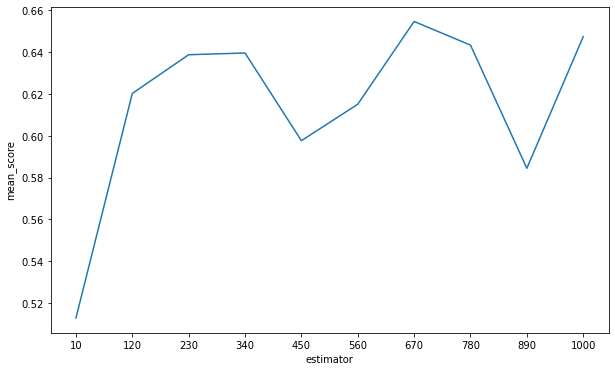

In [14]:
plt.figure(figsize=(10,6))
plt.xticks([10, 120, 230, 340, 450, 560, 670, 780, 890, 1000])
### Grouping the n_estimator values together to get a mean value
sns.lineplot(x= 'estimator',
             y='mean_score',
             data= random_param_df.groupby('estimator').mean('mean_score'))

**Analyzing the min_sample_leaf value**

In [15]:
random_param_df.groupby('param_min_samples_leaf').describe()['mean_score']

,count,mean,std,min,25%,50%,75%,max
param_min_samples_leaf,,,,,,,,
1,5.0,0.625860,0.020063,0.597683,0.613639,0.631757,0.638812,0.647408
2,4.0,0.563936,0.119919,0.402111,0.508398,0.599279,0.654817,0.655073
4,11.0,0.620024,0.024687,0.584980,0.594196,0.630917,0.638520,0.647454


we can see that although min_samples_leaf value 1 has higher mean score the max value achived by it is least compared to value 2 or 4. However, value 4 gives the best average result with 2 as the second best.

<AxesSubplot:xlabel='param_min_samples_leaf', ylabel='mean_score'>

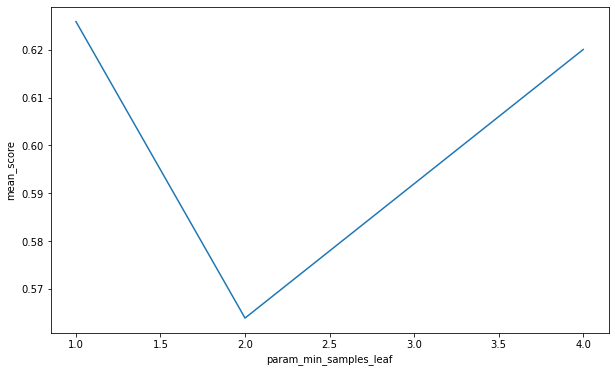

In [16]:
### Visualizing min_sample leaf results
plt.figure(figsize=(10,6))
sns.lineplot(x= 'param_min_samples_leaf',
             y='mean_score',
             data= random_param_df.groupby('param_min_samples_leaf').mean('mean_score'))

**Analyzing the min_sample_split value**

In [17]:
random_param_df.groupby('param_min_sample_split').describe()['mean_score']

,count,mean,std,min,25%,50%,75%,max
param_min_sample_split,,,,,,,,
2,6.0,0.613618,0.022441,0.584980,0.594888,0.618609,0.629938,0.638812
5,7.0,0.604827,0.091574,0.402111,0.614720,0.644983,0.651093,0.655073
10,7.0,0.612830,0.037732,0.543827,0.594196,0.630917,0.639634,0.647408


<AxesSubplot:xlabel='param_min_sample_split', ylabel='mean_score'>

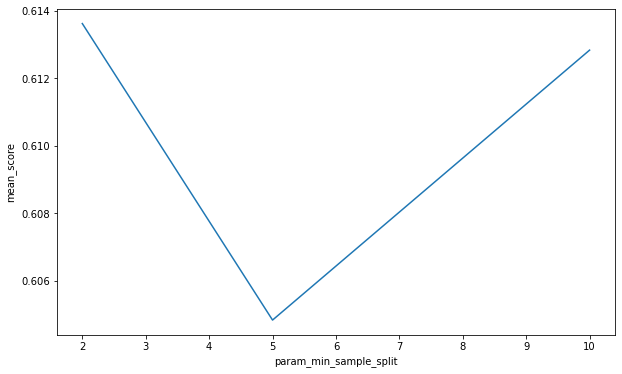

In [18]:
plt.figure(figsize=(10,6))
sns.lineplot(x= 'param_min_sample_split',
             y='mean_score',
             data= random_param_df.groupby('param_min_sample_split').mean('mean_score'))

**Analyzing the max_depth value**

<AxesSubplot:xlabel='param_max_depth', ylabel='mean_score'>

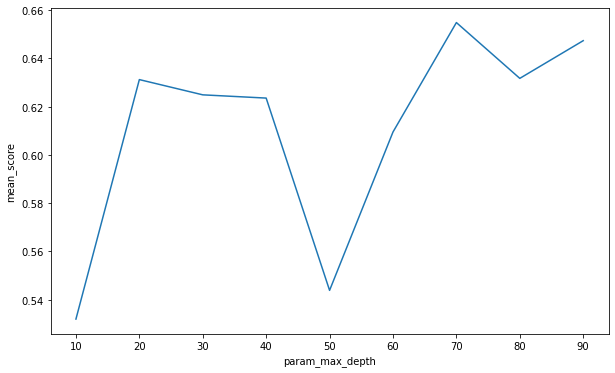

In [19]:
plt.figure(figsize=(10,6))
sns.lineplot(x= 'param_max_depth',
             y='mean_score',
             data= random_param_df.groupby('param_max_depth').mean('mean_score'))

Mean score is high for max_depth with value 70,90,80,20 and 40. We can use this range to further narrow down the best param values.

In [20]:
random_param_df.groupby('param_max_features').describe()['mean_score']

,count,mean,std,min,25%,50%,75%,max
param_max_features,,,,,,,,
0.5,5.0,0.636983,0.021995,0.597683,0.644983,0.647389,0.647408,0.647454
1,7.0,0.578907,0.080787,0.402111,0.586809,0.592415,0.622698,0.638812
auto,5.0,0.612452,0.038522,0.543827,0.623578,0.630917,0.631878,0.632057
sqrt,3.0,0.635260,0.034021,0.595977,0.625354,0.654731,0.654902,0.655073


`sqrt` and `0.5` has high max value as well as mean value.

**Fitting a second randomized search model with filtered param value to further narrow down the best parameter values.**

In [21]:
# Number of trees in random forest
n_estimators1 = [int(x) for x in np.linspace(start = 600, stop = 800, num = 10)]

# Number of features to consider at every split
max_features1 = ['sqrt',0.5]

# Maximum number of levels in tree
max_depth1 = [20,40,70,110]

# Minimum number of samples required to split a node
min_samples_split1 = [5,10]

# Minimum number of samples required at each leaf node
min_samples_leaf1 = [2, 4]

# Create the random grid
random_grid1 = {'n_estimators': n_estimators1,
               'max_features': max_features1,
               'max_depth': max_depth1,
               'min_samples_split': min_samples_split1,
               'min_samples_leaf': min_samples_leaf1}

In [22]:
random_grid1

{'n_estimators': [600, 622, 644, 666, 688, 711, 733, 755, 777, 800],
 'max_features': ['sqrt', 0.5],
 'max_depth': [20, 40, 70, 110],
 'min_samples_split': [5, 10],
 'min_samples_leaf': [2, 4]}

In [ ]:
# Random search of parameters, using 3 fold cross validation, 
# search across 40 different combinations, and use all available cores
random_rf1 = RandomizedSearchCV(estimator = rfr,
                                param_distributions = random_grid1,
                                cv = 3, 
                                n_iter= 40,
                                verbose=2)

In [ ]:
random_rf1.fit(X_train,y_train)

In [ ]:
random_rf1.cv_results_

In [23]:
### Creating a dictionary of the values from cv_results_
param1_dict = {'mean_score' : [0.65548971, 0.64767165, 0.64732684, 0.65461818, 0.65471639,
                              0.64820532, 0.64759574, 0.65494413, 0.64800324, 0.6476721 ,
                              0.64836527, 0.64784263, 0.64810392, 0.65320502, 0.64730878,
                              0.64802794, 0.64760472, 0.65465161, 0.64766866, 0.64801038,
                              0.64744121, 0.65531063, 0.65473897, 0.65462962, 0.65311673,
                              0.65466163, 0.64836464, 0.65343194, 0.65455235, 0.64799336,
                              0.65455097, 0.65478765, 0.64833389, 0.6551582 , 0.65524784,
                              0.65346536, 0.65504219, 0.65456178, 0.64803202, 0.65465529],
              
              'estimator' : [622, 666, 600, 600, 600, 800, 600, 711, 777, 644, 777,
                             777, 622, 733, 644, 644, 600, 777, 688, 644, 733, 777,
                             777, 733, 666, 688, 688, 666, 777, 600, 666, 777, 733,
                             733, 800, 711, 800, 711, 733, 622],
              
              'param_min_sample_split' : [5, 5, 10, 10, 5, 5, 10, 10, 10, 5, 5, 10, 10, 10, 10,
                                          10, 5, 5, 5, 10, 10, 5, 10, 5, 10, 10, 5, 10, 5, 10,
                                          10, 10, 5, 5, 5, 10, 5, 5, 10, 10],
              
              'param_min_samples_leaf':[2, 4, 4, 4, 4, 2, 4, 2, 2, 2, 2, 2, 2, 4, 4, 2, 4, 4,
                                        4, 2, 4, 2, 4, 4, 4, 4, 2, 2, 4, 2, 4, 4, 2, 2, 2, 2,
                                        2, 4, 2, 4],
              
              'param_max_features':['sqrt', 0.5, 0.5, 'sqrt', 'sqrt', 0.5, 0.5, 'sqrt',
                                     0.5, 0.5, 0.5, 0.5, 0.5, 'sqrt', 0.5, 0.5, 0.5, 'sqrt',
                                     0.5, 0.5, 0.5, 'sqrt', 'sqrt', 'sqrt', 'sqrt', 'sqrt',
                                     0.5, 'sqrt', 'sqrt', 0.5, 'sqrt', 'sqrt', 0.5, 'sqrt',
                                     'sqrt', 'sqrt', 'sqrt', 'sqrt', 0.5, 'sqrt'],
              
              'param_max_depth':[40, 40, 40, 70, 40, 40, 20, 110, 70, 20, 70, 20, 20,
                                 20, 110, 70, 110, 70, 110, 40, 70, 40, 40, 70, 20, 110,
                                 70, 20, 40, 110, 40, 110, 70, 70, 40, 20, 110, 70, 40,
                                 110]}

### Translating the dictonary to dataframe
random_param_df1 = pd.DataFrame.from_dict(param1_dict)

In [24]:
random_param_df1.sort_values('mean_score',ascending = False)

,mean_score,estimator,param_min_sample_split,param_min_samples_leaf,param_max_features,param_max_depth
0,0.655490,622,5,2,sqrt,40
21,0.655311,777,5,2,sqrt,40
34,0.655248,800,5,2,sqrt,40
33,0.655158,733,5,2,sqrt,70
36,0.655042,800,5,2,sqrt,110
7,0.654944,711,10,2,sqrt,110
31,0.654788,777,10,4,sqrt,110
22,0.654739,777,10,4,sqrt,40
4,0.654716,600,5,4,sqrt,40
25,0.654662,688,10,4,sqrt,110


From the above table it can be observed that optimal value of
* min_sample_split = 5 
* min_sample_leaf = 2 
* max_feature = sqrt 

Thus we can fix these values for the corresponding hyperparameter during the Grid Search. 

### Grid Search CV

Using exhaustive search method for hyperparameter tuning

In [25]:
# Number of trees in random forest
gs_estimator = [int(x) for x in np.linspace(start=620,stop=800,num=10)]

# Maximum number of levels in tree
gs_max_depth = [40,70,110]

# Creating grid for Grid Search CV
gs_grid = {'n_estimators' : gs_estimator,
           'max_depth': gs_max_depth}
gs_grid

{'n_estimators': [620, 640, 660, 680, 700, 720, 740, 760, 780, 800],
 'max_depth': [40, 70, 110]}

In [ ]:
# Use the random grid to search for best hyperparameters
# Using Random forest model with best values achived through randomized search CV as the base model 
gs_rfr = GridSearchCV(RandomForestRegressor(min_samples_split= 5,
                                            min_samples_leaf= 2,
                                            max_features='sqrt',
                                            n_jobs= -1),
                      param_grid = gs_grid, 
                      cv = 3,
                      verbose=2)

In [ ]:
gs_rfr.fit(X_train,y_train)

In [ ]:
### Best hyperparameter values and the corresponding score from Grid Search CV
gs_rfr.best_params_,gs_rfr.best_score_

Random search CV and Grid Search CV helped me narrow down the range of values, for the hyperparameters to a great extent. In the next step, I will maually tweak the values to try and improve the performance of the model further. 

I am storing the value of the hyperparameters and the scores received with that data in a dictionary.

In [63]:
### Creating the random forest regressor model with the best hyperparameter values
best_rfr = RandomForestRegressor(n_estimators=800,
                                 max_depth= 20,
                                 min_samples_split= 2,
                                 min_samples_leaf= 4,
                                 max_features= 0.5,
                                 n_jobs= -1)

In [64]:
### Fitting the best model with X_train and y_train
best_rfr.fit(X_train,y_train)

RandomForestRegressor(max_depth=20, max_features=0.5, min_samples_leaf=4,
                      n_estimators=800, n_jobs=-1)

In [40]:
### Scores achived using the best model
show_scores(best_rfr)

{'Training MAE': 3577.64,
 'Valid MAE': 5981.34,
 'Training RMSLE': 0.173,
 'Valid RMSLE': 0.246,
 'Training R^2': 0.941,
 'Valid R^2': 0.878}

In [29]:
myDict = {'n_estimators':[720,780,780,800,800,800],
          'max_depth': [40,40,20,20,20,20],
          'min_samples_split': [5,5,5,5,5,2],
          'min_samples_leaf': [2,2,2,2,2,4],
          'max_features':['sqrt','sqrt','sqrt',0.5,'sqrt',0.5],
          'Training MAE': [3166.91, 3169.7,4348.27,3260.99,4346.77,3579.91],
          'Valid MAE': [6371.83,6368.66,6525.04,5942.57,6513.76,5972.59],
          'Training RMSLE': [0.15,0.154,0.204,0.16,0.204,0.173],
          'Valid RMSLE': [0.264,0.264,0.27,0.246,0.269,0.246],
          'Training R^2': [0.95,0.953,0.918,0.952,0.918,0.941],
          'Valid R^2': [0.86,0.866,0.86,0.88,0.861,0.878]}
param_df = pd.DataFrame.from_dict(myDict)

In [30]:
param_df

,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,Training MAE,Valid MAE,Training RMSLE,Valid RMSLE,Training R^2,Valid R^2
0,720,40,5,2,sqrt,3166.91,6371.83,0.150,0.264,0.950,0.860
1,780,40,5,2,sqrt,3169.70,6368.66,0.154,0.264,0.953,0.866
2,780,20,5,2,sqrt,4348.27,6525.04,0.204,0.270,0.918,0.860
3,800,20,5,2,0.5,3260.99,5942.57,0.160,0.246,0.952,0.880
4,800,20,5,2,sqrt,4346.77,6513.76,0.204,0.269,0.918,0.861
5,800,20,2,4,0.5,3579.91,5972.59,0.173,0.246,0.941,0.878


## Make predictions

Let's test the performance of the model on the test data that was cleaned using the steps used to clean the train and valid data.

In [65]:
test_df = pd.read_csv('Processed Data/Test_clean.csv')

In [66]:
test_pred = best_rfr.predict(test_df)

The bechmark csv contains the true value of sales price for test csv. We will compare the values from our prediction to the values in the becnh csv to calculate the evaluation metric.

In [67]:
bench = pd.read_csv("./bluebook-for-bulldozers-data/random_forest_benchmark_test.csv")

In [68]:
true_val = bench.SalePrice
true_val

0        13630.0
1        32530.0
2        48660.0
3        96080.0
4        27440.0
          ...   
12452    59080.0
12453    10165.0
12454    11125.0
12455    13720.0
12456    28810.0
Name: SalePrice, Length: 12457, dtype: float64

In [69]:
### rmsle of the true value and the predicted value
np.sqrt(mean_squared_log_error(true_val, test_pred))

0.3000137337025846

## Feature Importance

Let's first create a function that can display the feature and it's importance in the form of a bar graph. This function will take in the feature importance value, name of the feature/column and the number of features we want to be displayed. This function will return a dataframe of feature name and it's importance score.

In [70]:
def display_feature_importance(feat_importance,columns,n_features):
    df_feat = pd.DataFrame({'Features': columns,
                            'Importance':feat_importance}).sort_values('Importance').reset_index(drop=True)
    plt.figure(figsize=(12,10))
    sns.barplot(x = df_feat['Importance'][:n_features],y = df_feat['Features'][:n_features],orient='h')
    return df_feat

The default method of feature importance used by random forest regressor is impurity based. This can result in a bisas towards data with high cardinality. Moreover, if the model is overfitting the training data the feature importance are not accurate.

More on this at: https://towardsdatascience.com/best-practice-to-calculate-and-interpret-model-feature-importance-14f0e11ee660

To analyse the true feature importance of our model we will calculate the value using the default method and permutation importance method

In [71]:
### Using the default method
model_F_importance = best_rfr.feature_importances_
model_F_importance

array([4.05998719e-02, 3.08107114e-02, 8.12178000e-02, 2.21419141e-03,
       3.52214762e-03, 1.35334603e-01, 4.54190381e-03, 5.76611954e-02,
       7.48718161e-02, 1.14433016e-01, 5.32283682e-02, 2.12671564e-01,
       2.96773507e-04, 2.04089481e-05, 6.86526229e-04, 9.83347933e-04,
       1.69637856e-03, 4.93457739e-04, 2.69006160e-05, 1.52655493e-03,
       1.31498528e-03, 1.31439555e-02, 6.35650570e-02, 5.17712814e-03,
       7.23597296e-03, 2.82801967e-03, 6.14521688e-03, 7.82941877e-03,
       7.28317251e-02, 3.04982691e-03, 4.11555597e-05, 0.00000000e+00])

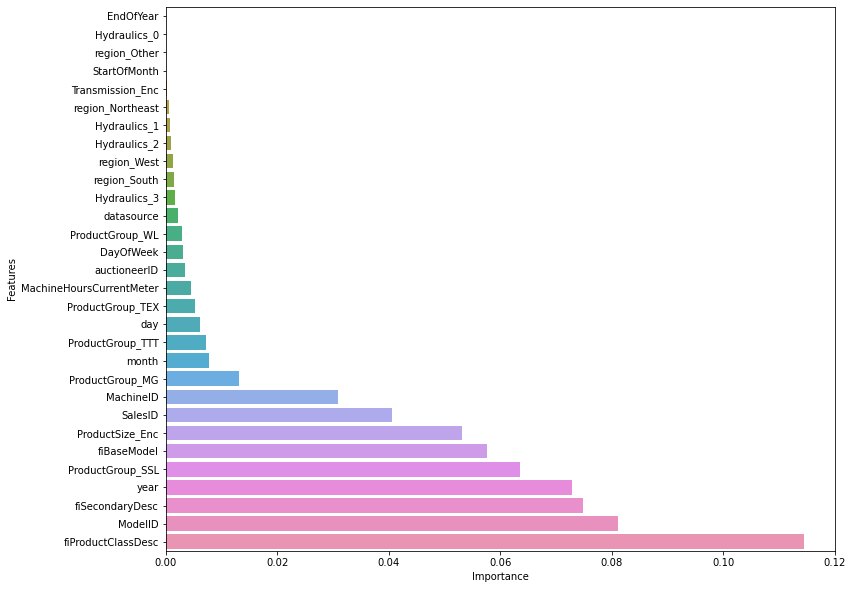

In [73]:
feat_df = display_feature_importance(model_F_importance,X_train.columns,30)

In [75]:
### Using permutation imprortance module
r = permutation_importance(best_rfr, X_train, y_train,n_repeats= 10,random_state=42)
r.importances_mean

array([4.75688541e-02, 1.66828612e-02, 9.52402603e-02, 1.84428053e-03,
       4.11184809e-03, 5.91786875e-01, 4.31397632e-03, 7.58075432e-02,
       1.80824885e-01, 2.95530631e-01, 1.54411408e-01, 6.50456687e-02,
       1.93692073e-04, 4.03103808e-06, 4.90372856e-04, 1.06363046e-03,
       9.73330667e-04, 4.83650667e-04, 1.99901411e-05, 2.13398020e-03,
       1.97189228e-03, 2.58163614e-02, 1.91871708e-01, 6.71382312e-03,
       1.01042015e-02, 2.61951916e-03, 6.16204346e-03, 1.16653249e-02,
       2.86760765e-01, 3.23281714e-03, 2.38830540e-05, 0.00000000e+00])

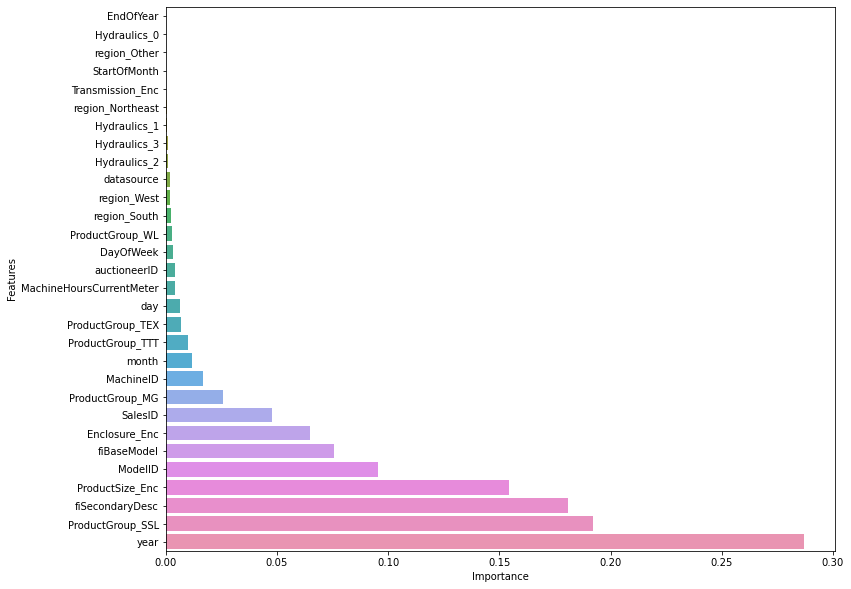

In [76]:
permute_feat_df = display_feature_importance(r.importances_mean, X_train.columns,30)

The feature importance obtained through permutation importance makes more sense as the sale year is the most important feature to be considered for prediction. Since, we are working with time series and sale price prediction for future the year of sale is of prime importance.